In [1]:
!pip install tensorflow==2.9.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.9.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.9.1


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


DATA PREPROCESSING

In [ ]:
import zipfile

# Generate data paths with labels
data_dir = '/BRAIN_TUMOR_DATASET.zip'
filepaths = []
labels = []

# Extract the zip file to a temporary directory
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('temp_dataset')

# Use the temporary directory to list files
folds = os.listdir('temp_dataset')
for fold in folds:
    foldpath = os.path.join('temp_dataset', fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

,filepaths,labels
0,temp_dataset/brain_tumor_dataset/no,brain_tumor_dataset
1,temp_dataset/brain_tumor_dataset/yes,brain_tumor_dataset
2,temp_dataset/no/No17.jpg,no
3,temp_dataset/no/4 no.jpg,no
4,temp_dataset/no/no 98.jpg,no
...,...,...
250,temp_dataset/yes/Y159.JPG,yes
251,temp_dataset/yes/Y103.jpg,yes
252,temp_dataset/yes/Y92.jpg,yes
253,temp_dataset/yes/Y254.jpg,yes


In [ ]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


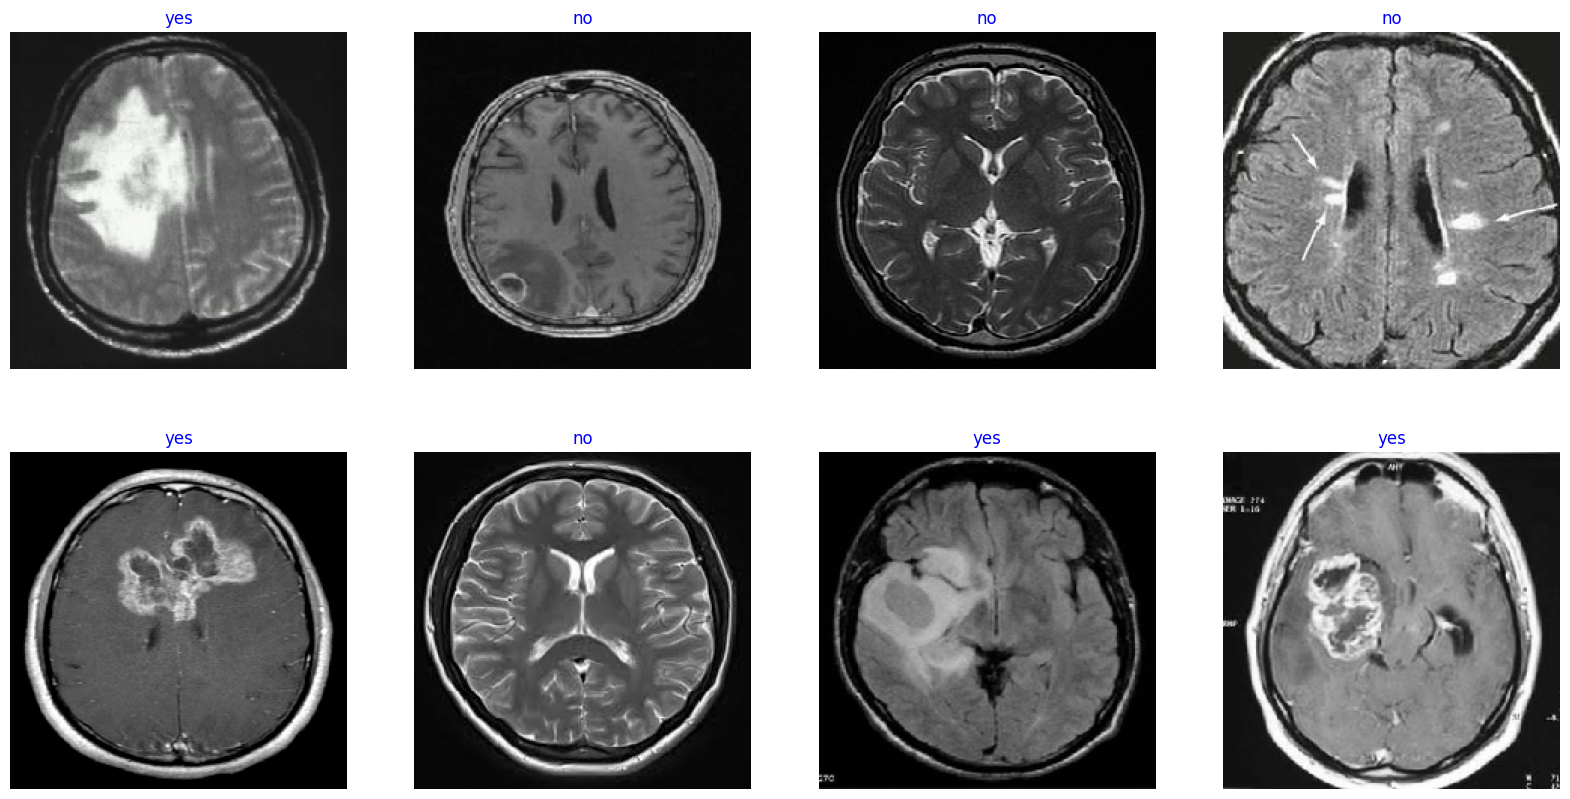

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

MODEL STRUCTURE

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet",
                                                               input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006), # Changed line: pass 0.016 as a positional argument
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [ ]:
epochs = 30   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.6064 - loss: 13.9969 - val_accuracy: 0.6863 - val_loss: 22.0891
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.7891 - loss: 10.6266 - val_accuracy: 0.6863 - val_loss: 21.3787
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.8457 - loss: 7.8940 - val_accuracy: 0.7647 - val_loss: 13.6864
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.8287 - loss: 7.1648 - val_accuracy: 0.7059 - val_loss: 10.8332
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.7980 - loss: 6.7305 - val_accuracy: 0.8235 - val_loss: 8.7481
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.8201 - loss: 6.3489 - val_accuracy: 0.8627 - val_loss: 7.2012
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.8264 - loss: 6.0546 - val_accuracy: 0.9020 - val_loss: 6.8085
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.8374 - loss: 5.8831 - val_accuracy: 0.88

display model performance

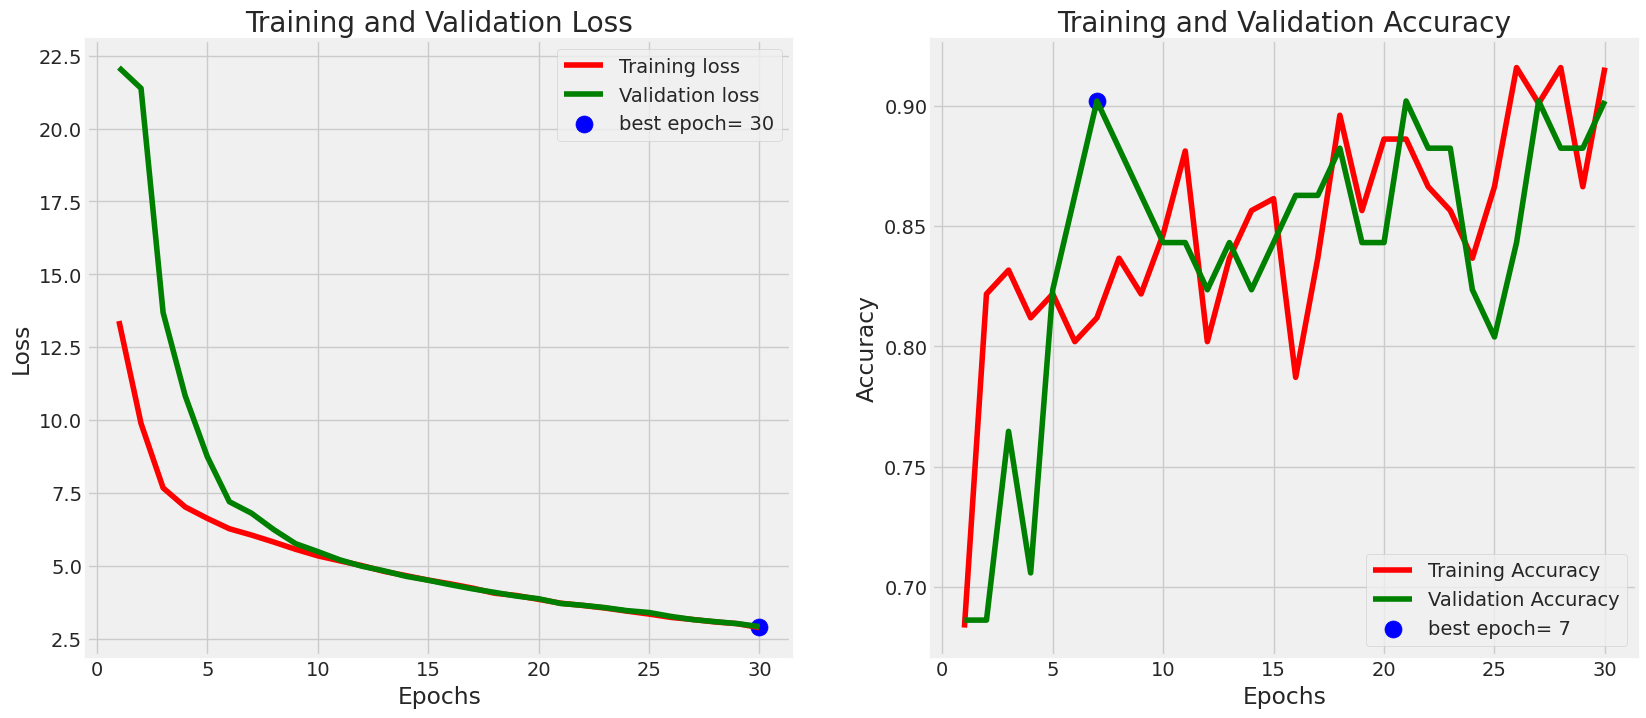

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

EVALUTE MODEL

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 847ms/step - accuracy: 0.9792 - loss: 2.8681
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 882ms/step - accuracy: 0.9330 - loss: 2.8775
Train Loss:  2.85558819770813
Train Accuracy:  0.9801980257034302
--------------------
Test Loss:  2.9213693141937256
Test Accuracy:  0.9019607901573181


GET PREDICTIONS

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 803ms/step


Text(0.5, 79.3718389733912, 'Predicted Label')

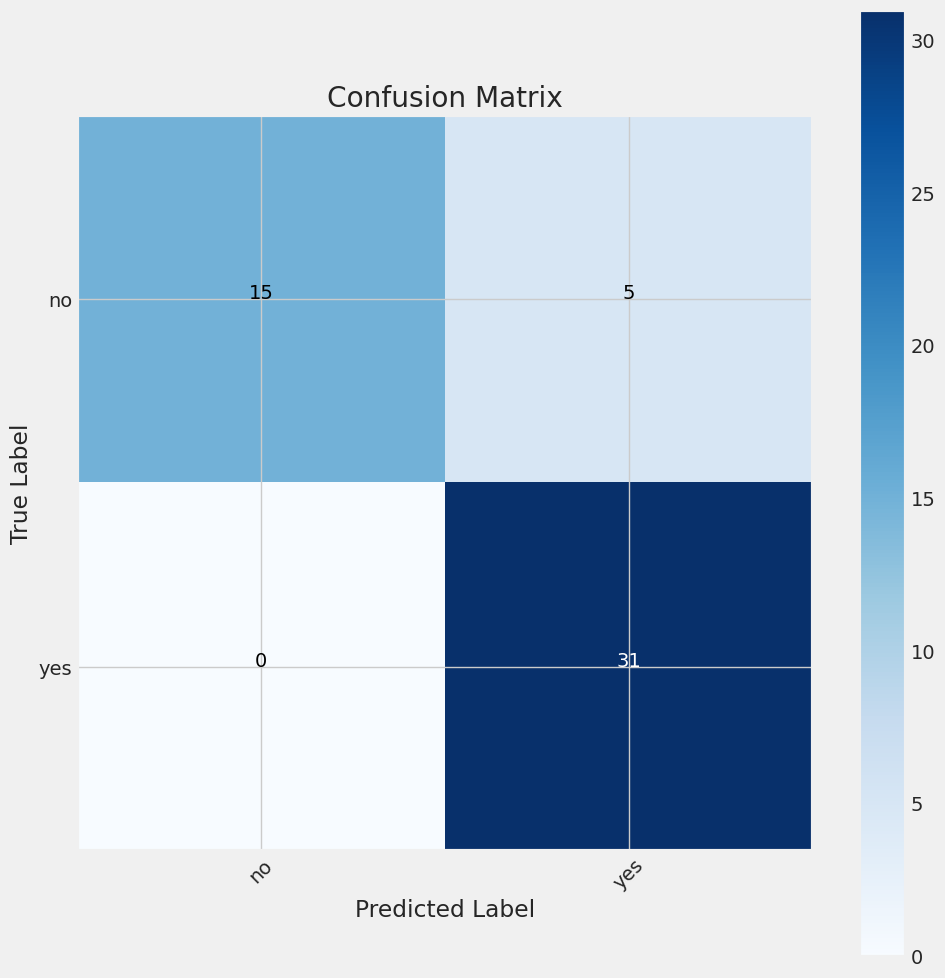

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       1.00      0.75      0.86        20
         yes       0.86      1.00      0.93        31

    accuracy                           0.90        51
   macro avg       0.93      0.88      0.89        51
weighted avg       0.92      0.90      0.90        51



In [ ]:
#Save the model
model.save('Model.h5')